In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 23.2 MB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 58.2 MB/s eta 0:00:01


In [9]:
from braket.aws import AwsDevice, AwsQuantumTask
from braket.devices import LocalSimulator

import pennylane as qml
import tensorflow as tf
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from pennylane import numpy as np

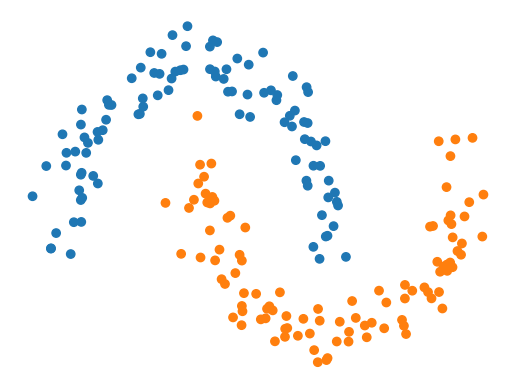

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

x, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()

In [24]:
# Number of qubits
n_wires = 5
n_qubits = 5

my_bucket = f"amazon-braket-2272e7b0d92e" # the name of the bucket
my_prefix = "quantum-playground" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

#https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html
#device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
device_arn = "arn:aws:braket:::device/qpu/ionq/ionQdevice"
#dev = qml.device("braket.local.qubit", wires=n_wires)
dev = qml.device('braket.aws.qubit', device_arn=device_arn, wires=n_wires, s3_destination_folder=s3_folder)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [25]:
# Convert quantum layer to keras
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

# Define classical layers
clayer_1 = tf.keras.layers.Dense(2)
clayer_2 = tf.keras.layers.Dense(2, activation="sigmoid")

In [ ]:
model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
fitting = model.fit(x, y_hot, epochs=10, batch_size=5, validation_split=0.25, verbose=2)

Epoch 1/10


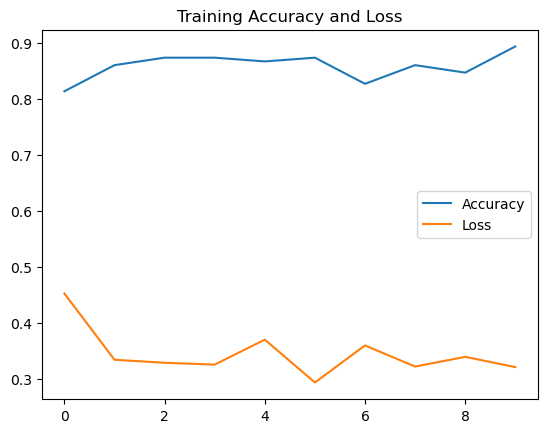

In [15]:
plt.plot(fitting.history['accuracy'], label='Accuracy')
plt.plot(fitting.history['loss'], label='Loss')
plt.legend(loc='best')
plt.title('Training Accuracy and Loss')
plt.show()

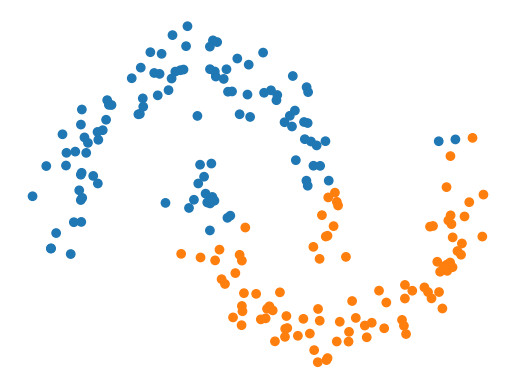

In [16]:
y_prob = model.predict(x)
y_class = y_prob.argmax(axis=-1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y_class]  # colours for each class
plt.axis("off")
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()